In [ ]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

# 修正したモデルから卒論時に集計したデータを作成する

1. 表

| ベンチマーク名 | 平均誤差率(%) | コスト比(%) |
|---------|----------|---------|


2. 表

| ベンチマーク名 | 採用割合(最大MAPE(%), 最小MAPE(%)) |
|---------|----------------------------|
|         | モデル(1), モデル(2), ...        |


* 平均誤差率：大規模実行時の関数コール回数との比較
* MAPE：トレーニングデータとの比較

In [ ]:
plt.figure(figsize=(4, 3))
plt.xlabel("使用したプロファイル数")
plt.ylabel("平均誤差率(%)")

In [ ]:
# pd.get_option("display.max_columns")
# pd.get_option("display.max_rows")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [ ]:
# ベンチマーク名・関数名・プロセス数・問題サイズを指定することで、その条件での関数コール回数を取得する関数

def returnSpecificData(benchmarkName="cg", functionName=".TAU_application", process=256, benchmarkClass="D"):
    targetRawDF = returnRawDF(Benchmark=benchmarkName, functionName=functionName, benchmarkClass=[
                              benchmarkClass], FixedProcess=process, Processes=[process], FixedBenchmarkClass=benchmarkClass)
    return targetRawDF.iat[0, 0]
# returnSpecificData(benchmarkName="mg", functionName="BUBBLE", process=256, benchmarkClass="B")

In [ ]:
# benchmarksからbt, spを除外する
benchmarks = [benchmark for benchmark in benchmarks if benchmark !=
              'bt' and benchmark != 'sp']
# pandasのDFをprintした時の幅を広げる
pd.set_option('display.width', 100)

In [ ]:
dictTmp = returnDictForPlotPerNumOfUsedData(Benchmark=benchmarks, fix="Class", benchmarkClass=[
    "A", "B", "C", "D"], FixedProcess=64, Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="C")

In [ ]:
pd.options.display.float_format = '{:.4g}'.format

tmpDF = pd.DataFrame()
for benchmark in benchmarks:
    listToLearn = [1, 2, 4, 8, 16, 32, 64, 128]
    listToPredict = [256]
    benchmark_x = dictTmp[benchmark]["x"]
    benchmark_y = dictTmp[benchmark]["y"]
    index = benchmark_x.index(len(listToLearn))
    MAPE = benchmark_y[index]
    relativeCost = returnRelativeCost(benchmark=benchmark, variablesToLearn=listToLearn,
                                      variablesToPredict=listToPredict, fixedClassOrProcess="Class", fixed="C")
    dictRowData = {"ベンチマーク名": benchmark.upper(
    ), "平均絶対誤差率[％]": MAPE, "相対コスト[％]": relativeCost}
    iDF = pd.DataFrame.from_dict(dictRowData, orient='index').T
    tmpDF = tmpDF.append(iDF)
tmpDFMean = tmpDF.mean()
type(tmpDFMean)
print(tmpDF.to_latex(index=False))

In [ ]:
# dictTmp

plt.figure(figsize=(5.72, 4), dpi=200)
for benchmark in list(dictTmp.keys()):
    x = dictTmp[benchmark]["x"]
    y = dictTmp[benchmark]["y"]
    plt.plot(x, y, marker='o', label=benchmark.upper())
    plt.legend()
    plt.xlabel("使用したプロファイル数")
    plt.ylabel("平均絶対誤差率[％]")

In [ ]:
plt.figure(figsize=(5.72, 4), dpi=200)

# Extra-PでfixProcessデータを入力して出力したモデルの図時
plot_x = np.linspace(0.8, 256, 500)
# -3590464.6990329633 + 3759195.349891038 * p^(1/4)
plot_y = []
for x in plot_x:
    plot_y.append(2286768.3333333326 + 301997.61904761934 * math.log2(x)**(1))
plt.plot(plot_x, plot_y, label="ExtraP")

x = [1, 2, 4, 8, 16, 32, 64, 128]
y = [1984770.0, 2263540.0, 2821070.0, 3936140.0,
     3936140.0, 3936140.0, 3936140.0, 3936140.0]
x = np.array(x).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)
plt.scatter(x, y, marker="o", label="予測に用いた関数コール回数")
plot_x = np.array(plot_x).reshape(-1, 1)
x_target = [256]
y_target = [3936140]
plt.scatter(x_target, y_target, marker="o", label="予測したい関数コール回数の実測値")

benchmarkName = "CG"
functionName = "ICNVRT"

# 線形モデル
# 対数モデル

# 反比例モデル
modelIpMk2 = ModelIp_mk2(train_x=x, train_y=y, target_x=x_target, target_y=y_target,
                         benchmark_name=benchmarkName, function_name=functionName)
modelIpMk2.calc_lr()
plot_y_IpMk2 = modelIpMk2.predict(plot_x)
plt.plot(plot_x, plot_y_IpMk2, label="反比例モデル")
# 線形飽和モデル
modelBranchMk2 = ModelBranch_mk2(train_x=x, train_y=y, target_x=x_target,
                                 target_y=y_target, benchmark_name=benchmarkName, function_name=functionName)
modelBranchMk2.calc_lr()
plot_y_BranchMk2 = modelBranchMk2.predict(plot_x)
plt.plot(plot_x, plot_y_BranchMk2, label="線形飽和モデル")
# # 線形モデル
# model_lin = ModelLin(x, y, "CG", "ICNVRT", test_ratio=0)
# model_lin.calc_lr()
# plot_y_lin = model_lin.predict(plot_x)
# plt.plot(plot_x, plot_y_lin, label="線形モデル")
# # 対数モデル
# model_log10 = ModelLog10(x, y, "CG", "ICNVRT", test_ratio=0)
# model_log10.calc_lr()
# plot_y_log10 = model_log10.predict(plot_x)
# plt.plot(plot_x, plot_y_log10, label="対数モデル")
# # 反比例モデル
# model_ip = ModelIP(x, y, "CG", "ICNVRT", test_ratio=0)
# model_ip.calc_lr()
# plot_y_ip = model_ip.predict(plot_x)
# plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# # 線形飽和モデル
# model_branch = ModelBranch(x, y, "CG", "ICNVRT", test_ratio=0)
# model_branch.calc_lr()
# plot_y_branch = model_branch.predict(plot_x)
# plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("実行コア数")

plt.scatter(x, y, marker="o")

In [ ]:
# 実際にプロットする


# print(f"fix={fix}, benchmarkClasses={benchmarkClasses}, fixedProcess={fixedProcess}, Processes={processes}, FixedBenchmarkClass={fixedBenchmarkClass}")
# print(f"targetNumOfProcess={targetNumOfProcess}, targetProblemSize={fixedBenchmarkClass}, fix={fix}")

# DF = returnRawDFperBenchmark(Benchmark="mg", fix="Process", benchmarkClass=["A", "B", "C", "D"], Processes=[
#                              1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="B", FixedProcess=64)
# DF.dropna(how='any')
# DF

In [ ]:
%reset

In [6]:
# ノートブック中で変数のみを記述することでデータフレームをきれいに表示させる設定の有効化
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
# ipynb形式のライブラリのインポート
%run ./lib/lib.ipynb

In [8]:
benchmarkNamesExcludeBTSP = ["cg", "ep", "ft", "is", "lu", "mg"]
# classes = ["A", "B", "C", "D"]
classes = ["B"]
processes = [1, 2, 4, 8, 16, 32, 64, 128, 256]
targetIndex = -1
csvDirPath = "./csv_files/"

dfByDatumExcludeBTSP = returnDFSummarizedData(
    benchmarkNames=benchmarkNamesExcludeBTSP, classes=classes, processes=processes, targetIndex=targetIndex, csvDirPath=csvDirPath)
# dfByDatumExcludeBTSP

dictForLatexTable = {}
for benchmarkName in benchmarkNamesExcludeBTSP:
    dictForLatexTable[benchmarkName] = dfByDatumExcludeBTSP[dfByDatumExcludeBTSP["benchmarkName"] == benchmarkName]

In [9]:
# 入力：returnSeriesOfDataを結合したDF（含むベンチマークの種類は1つ）
# 出力：各モデルの採用割合が入ったSeries
def returnSeriesOfDatumPerBenchmark(inputDF):
    # 全データが単一のベンチマークによるものかを確認し、そうでなければ警告を出力する
    listOfBenchmarkNameInInputDF = inputDF["benchmarkName"].tolist()
    noDuplicateBenchmarkName = list(set(listOfBenchmarkNameInInputDF))
    if (len(noDuplicateBenchmarkName) != 1):
        warnings.warn("入力DFには複数のベンチマークの結果が含まれています")
    benchmarkName = noDuplicateBenchmarkName[0]
    numOfInputDF = len(inputDF)
    modelNames = ["ModelIp", "ModelLog", "ModelBranch", "ModelLin"]
    contentList = [benchmarkName.upper()]
    summarizedRateExcludeModelLin = 0
    for modelName in modelNames:
        dfOfModel = inputDF[inputDF["objectBestModelName"] == modelName]
        numOfModel = len(dfOfModel)
        rateOfModel = int(numOfModel/numOfInputDF * 100)

        try:
            maxInDfOfModel = int(dfOfModel["MAPEOfBestModel"].max()*10)/10
        except:
            maxInDfOfModel = "-"

        try:
            minInDfOfModel = int(dfOfModel["MAPEOfBestModel"].min()*10)/10
        except:
            minInDfOfModel = "-"

        if modelName != "ModelLin":
            summarizedRateExcludeModelLin += rateOfModel
        elif modelName == "ModelLin":
            rateOfModel = 100 - summarizedRateExcludeModelLin

        instanceDatumAboutRateOfModel = DatumAboutRateOfModel(
            modelName=modelName, rateOfModel=rateOfModel, minMAPE=minInDfOfModel, maxMAPE=maxInDfOfModel)
        contentList.append(instanceDatumAboutRateOfModel.returnFormattedStr())
    columnList = ["benchmarkName"] + modelNames
    returnSeries = pd.Series(data=contentList, index=columnList)
    return(returnSeries)


class DatumAboutRateOfModel:
    def __init__(self, modelName, rateOfModel, minMAPE, maxMAPE):
        # モデル名
        self.modelName = modelName
        # モデルの被採用率
        self.rateOfModel = rateOfModel
        # モデルの最小MAPE・最大MAPE
        self.minMAPE = minMAPE
        self.maxMAPE = maxMAPE

    def returnFormattedStr(self):
        if (self.maxMAPE == "-" or self.minMAPE == "-"):
            strMinMax = "-"
        else:
            strMinMax = (f"{self.minMAPE},{self.maxMAPE}")
        returnStr = f"{self.rateOfModel}({strMinMax})"
        return(returnStr)

listForDF = []

for benchmarkName in benchmarkNamesExcludeBTSP:
    listForDF.append(returnSeriesOfDatumPerBenchmark(
        inputDF=dictForLatexTable[benchmarkName]))
DF = pd.DataFrame(listForDF)
print(DF.to_latex(index=False))

# テストについて
# 各モデルがそれぞれカウントされている
# 入力データ数と各モデルのカウント値の最大値が同じ

\begin{tabular}{lllll}
\toprule
benchmarkName &      ModelIp &      ModelLog &  ModelBranch &     ModelLin \\
\midrule
           CG &         0(-) & 13(23.0,23.0) &  18(0.0,0.0) &  69(0.0,0.0) \\
           EP &         0(-) &          0(-) &         0(-) & 100(0.0,0.0) \\
           FT &         0(-) &          0(-) & 38(0.0,64.9) &  62(0.0,0.0) \\
           IS &         0(-) & 14(11.5,11.5) & 4(64.9,64.9) &  82(0.0,0.0) \\
           LU & 23(0.0,28.1) &          0(-) &         0(-) &  77(0.0,0.0) \\
           MG &         0(-) &    4(0.5,0.5) &         0(-) &  96(0.0,3.2) \\
\bottomrule
\end{tabular}



,benchmarkName,functionName,usedDataX,usedDataY,numOfData,ProcessOrClass,fixed,targetProcess,targetProblemSize,targetNumOfFunctionCall,objectLinModel,MAPEOfLinModel,objectIpModel,MAPEOfIpModel,objectLogModel,MAPEOfLogModel,objectBranchModel,MAPEOfBranchModel,objectBestModelName,MAPEOfBestModel
72,is,double_randlc(double_*_double_*),"[1, 2, 4, 8, 16, 32, 64, 128]","[131099.0, 67108900.0, 33554500.0, 16777200.0,...",8,Class,B,256,B,524317.0,<__main__.ModelLin object at 0x7f35a0036670>,[84.45309104587679],<__main__.ModelIp object at 0x7f35a0036f40>,[91.49589975684003],<__main__.ModelLog10 object at 0x7f35a00363a0>,[86.87159044449669],<__main__.ModelBranch object at 0x7f35a0036400>,[64.9528737428156],ModelBranch,[64.9528737428156]


benchmarkName                                                             is
functionName                                double_randlc(double_*_double_*)
usedDataX                                      [1, 2, 4, 8, 16, 32, 64, 128]
usedDataY                  [131099.0, 67108900.0, 33554500.0, 16777200.0,...
numOfData                                                                  8
ProcessOrClass                                                         Class
fixed                                                                      B
targetProcess                                                            256
targetProblemSize                                                          B
targetNumOfFunctionCall                                             524317.0
objectLinModel                  <__main__.ModelLin object at 0x7f35a0036d00>
MAPEOfLinModel                                           [84.45309104587679]
objectIpModel                    <__main__.ModelIp object at 0x7f35a0036af0>

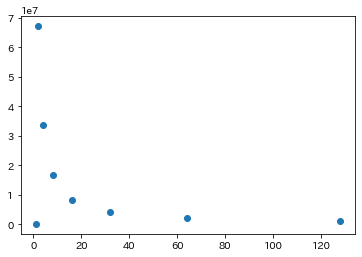

In [13]:
resultIs = dictForLatexTable["is"]
# resultIs
resultIsAtModelBranch = resultIs[resultIs["objectBestModelName"]=="ModelBranch"]
dataX = resultIsAtModelBranch["usedDataX"].tolist()[0]
dataY = resultIsAtModelBranch["usedDataY"].tolist()[0]
resultIsAtModelBranch

plt.scatter(dataX, dataY)

returnSeriesOfData(benchmarkName="is", functionName="double_randlc(double_*_double_*)", rawX=dataX, rawY=dataY, fixProcessOrClass="Class", fixed="B", targetProcess=256, targetBenchmarkClass="B", targetFunctionCallNum=-1, csvDirPath="./csv_files")


,benchmarkName,functionName,usedDataX,usedDataY,numOfData,ProcessOrClass,fixed,targetProcess,targetProblemSize,targetNumOfFunctionCall,objectLinModel,MAPEOfLinModel,objectIpModel,MAPEOfIpModel,objectLogModel,MAPEOfLogModel,objectBranchModel,MAPEOfBranchModel,objectBestModelName,MAPEOfBestModel
34,ft,CFFTZ,"[1, 2, 4, 8, 16, 32, 64, 128]","[2048.0, 225280.0, 112640.0, 56320.0, 28160.0,...",8,Class,B,256,B,1760.0,<__main__.ModelLin object at 0x7fb4d98560a0>,[84.06318253080923],<__main__.ModelIp object at 0x7fb4d9856cd0>,[90.80977446487935],<__main__.ModelLog10 object at 0x7fb4d9856a00>,[84.14488172695901],<__main__.ModelBranch object at 0x7fb4d9856d00>,[64.95287245243205],ModelBranch,[64.95287245243205]
40,ft,FFTZ2,"[1, 2, 4, 8, 16, 32, 64, 128]","[15360.0, 1847300.0, 923648.0, 461824.0, 23091...",8,Class,B,256,B,14432.0,<__main__.ModelLin object at 0x7fb4d9843b20>,[84.10545960969354],<__main__.ModelIp object at 0x7fb4d9843130>,[90.88379877512276],<__main__.ModelLog10 object at 0x7fb4d9843d30>,[84.41534845452642],<__main__.ModelBranch object at 0x7fb4d98439a0>,[64.9529004977285],ModelBranch,[64.9529004977285]
55,ft,SET_CLASS,"[1, 2, 4, 8, 16, 32, 64, 128]","[0.00390625, 0.5, 0.25, 0.125, 0.0625, 0.03125...",8,Class,B,256,B,0.003906,<__main__.ModelLin object at 0x7fb4d977a580>,[84.13279003925463],<__main__.ModelIp object at 0x7fb4d977abb0>,[90.93179102852946],<__main__.ModelLog10 object at 0x7fb4d97876d0>,[84.59393830443615],<__main__.ModelBranch object at 0x7fb4d9787100>,[64.95287245243205],ModelBranch,[64.95287245243205]


[[1, 2, 4, 8, 16, 32, 64, 128],
 [1, 2, 4, 8, 16, 32, 64, 128],
 [1, 2, 4, 8, 16, 32, 64, 128]]

[[2048.0, 225280.0, 112640.0, 56320.0, 28160.0, 14080.0, 7040.0, 3520.0],
 [15360.0,
  1847300.0,
  923648.0,
  461824.0,
  230912.0,
  115456.0,
  57728.0,
  28864.0],
 [0.00390625, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

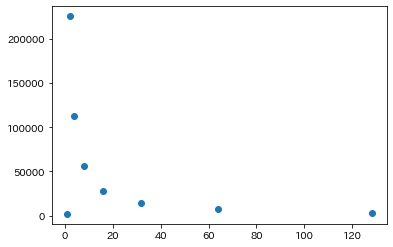

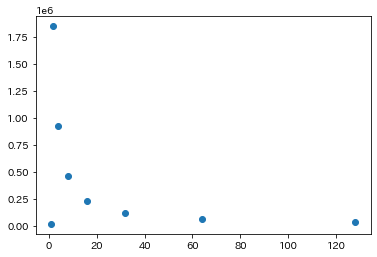

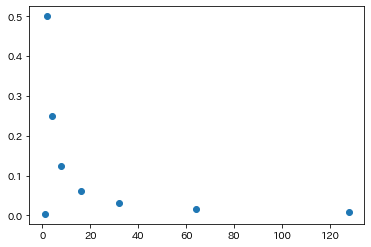

In [28]:
resultIs = dictForLatexTable["ft"]
# resultIs
resultIsAtModelBranch = resultIs[resultIs["objectBestModelName"]=="ModelBranch"]
resultIsAtModelBranchOfNotLowMAPE = resultIsAtModelBranch[resultIsAtModelBranch["MAPEOfBestModel"] > 1]
resultIsAtModelBranchOfNotLowMAPE
datumX = resultIsAtModelBranchOfNotLowMAPE["usedDataX"].tolist()
datumY = resultIsAtModelBranchOfNotLowMAPE["usedDataY"].tolist()

datumX
datumY

for dataIndex in range(len(datumX)):
    plt.figure()
    plt.scatter(datumX[dataIndex], datumY[dataIndex])

# returnSeriesOfData(benchmarkName="is", functionName="double_randlc(double_*_double_*)", rawX=dataX, rawY=dataY, fixProcessOrClass="Class", fixed="B", targetProcess=256, targetBenchmarkClass="B", targetFunctionCallNum=-1, csvDirPath="./csv_files")


In [ ]:
# 生データの取得
cgDF = returnCollectedExistingData(benchmarkNames=["cg"], classes=["A", "B", "C", "D"], processes=[
                                   1, 2, 4, 8, 16, 32, 64, 128, 256], csvDirPath="./csv_files/")
cgDF
# ベンチマーククラスがAの情報を取得
cgDFfixedA = cgDF[cgDF["benchmarkClass"] == "A"]
cgDFfixedA
# 関数名のリストを取得
functionNames = sorted(list(set(cgDFfixedA["functionName"])))
print(functionNames)

# 関数名を関数名のリストから抽出
functionNameCG = cgDFfixedA[cgDFfixedA["functionName"] == "CG"]
functionNameCG

# 説明変数と目的変数とをリスト化したものを抽出
# プロセス数
raw_x = functionNameCG['process'].tolist()
# 関数コール回数
raw_y = functionNameCG['functionCallNum'].tolist()

print(f"raw_x={raw_x}")
print(f"raw_y={raw_y}")

bencmarkName = "CG"
functionName = "CG"
fixProcessOrClass = "Class"
fixed = "A"
targetProcess = 256
targetBenchmarkClass = fixed
targetFunctionCallNum = raw_y[-1]
returnSeriesOfData(benchmarkName="benhmarkName", functionName="functionName", rawX=[1, 2, 3], rawY=[
                   1, 2, 3], fixProcessOrClass="Class", fixed="B", targetProcess=256, targetBenchmarkClass="B", targetFunctionCallNum=-1, csvDirPath="./csv_files/")